In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost lightgbm fastapi

In [2]:
import pandas as pd
import numpy as np

# 1. Data Loading
df = pd.read_csv('./dataset/taxi_trip_pricing.csv')
df.head()

# Initial Data Exploration
print("\nDataFrame Info:")
print(df.info())

print("\nDescriptive Statistics for Numeric Columns:")
print(df.describe())


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Trip_Distance_km       950 non-null    float64
 1   Time_of_Day            950 non-null    object 
 2   Day_of_Week            950 non-null    object 
 3   Passenger_Count        950 non-null    float64
 4   Traffic_Conditions     950 non-null    object 
 5   Weather                950 non-null    object 
 6   Base_Fare              950 non-null    float64
 7   Per_Km_Rate            950 non-null    float64
 8   Per_Minute_Rate        950 non-null    float64
 9   Trip_Duration_Minutes  950 non-null    float64
 10  Trip_Price             951 non-null    float64
dtypes: float64(7), object(4)
memory usage: 86.1+ KB
None

Descriptive Statistics for Numeric Columns:
       Trip_Distance_km  Passenger_Count   Base_Fare  Per_Km_Rate  \
count        950.000000      

In [3]:
# Check missing values for each column
print("\nMissing Values:")
print(df.isnull().sum())

# 2. Dropping rows missing target
df = df.dropna(subset=['Trip_Price'])
print("Missing values after dropping rows with missing 'Trip_Price':")
print(df.isnull().sum())


Missing Values:
Trip_Distance_km         50
Time_of_Day              50
Day_of_Week              50
Passenger_Count          50
Traffic_Conditions       50
Weather                  50
Base_Fare                50
Per_Km_Rate              50
Per_Minute_Rate          50
Trip_Duration_Minutes    50
Trip_Price               49
dtype: int64
Missing values after dropping rows with missing 'Trip_Price':
Trip_Distance_km         50
Time_of_Day              49
Day_of_Week              46
Passenger_Count          48
Traffic_Conditions       50
Weather                  46
Base_Fare                44
Per_Km_Rate              44
Per_Minute_Rate          49
Trip_Duration_Minutes    46
Trip_Price                0
dtype: int64


In [4]:
# 3. Outlier Handling
numeric_cols = ["Trip_Distance_km", "Trip_Duration_Minutes", "Base_Fare", 
                "Per_Km_Rate", "Per_Minute_Rate", "Trip_Price"]

def remove_outliers(data, cols, multiplier=1.5):
    df_out = data.copy()
    for col in cols:
        if df_out[col].isnull().all() or df_out[col].nunique() < 2:
            continue
        Q1 = df_out[col].quantile(0.25)
        Q3 = df_out[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        df_out = df_out[(df_out[col] >= lower_bound) & (df_out[col] <= upper_bound)]
    return df_out

df_clean = remove_outliers(df, numeric_cols, multiplier=1.5)
print("\nShape before outlier removal:", df.shape)
print("Shape after outlier removal:", df_clean.shape)


Shape before outlier removal: (951, 11)
Shape after outlier removal: (714, 11)


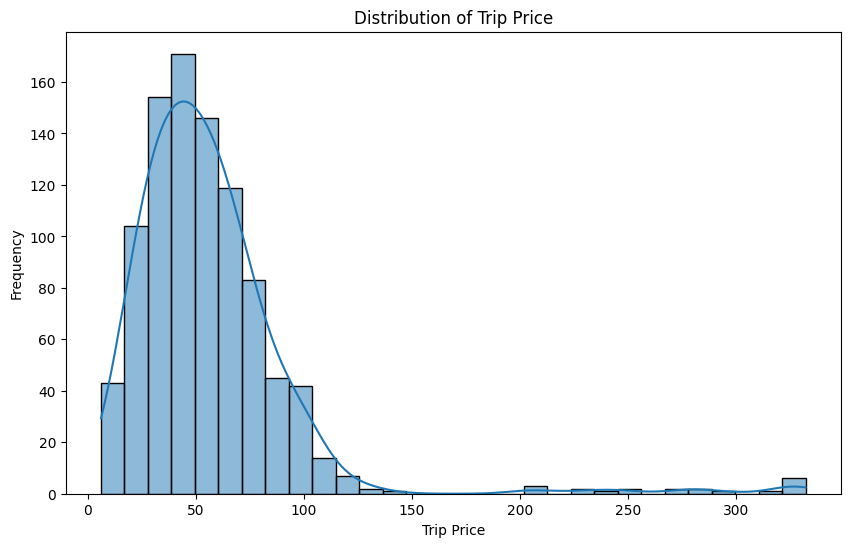

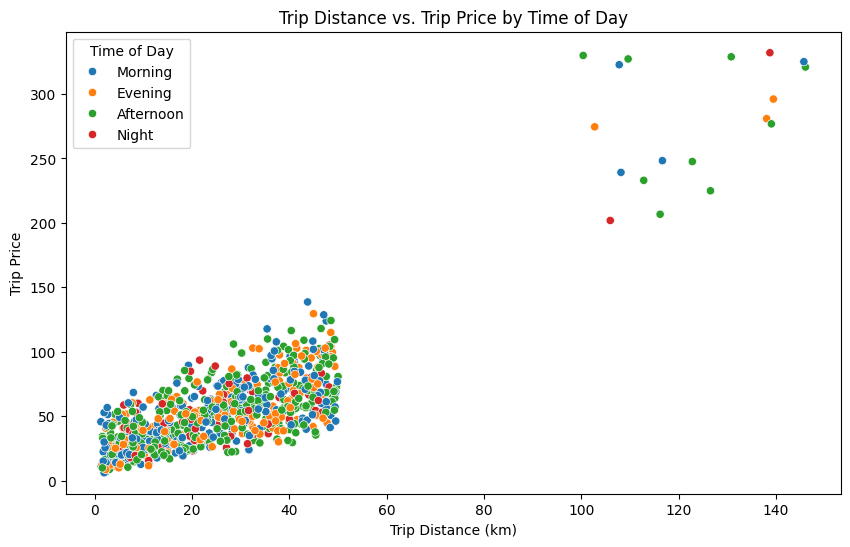

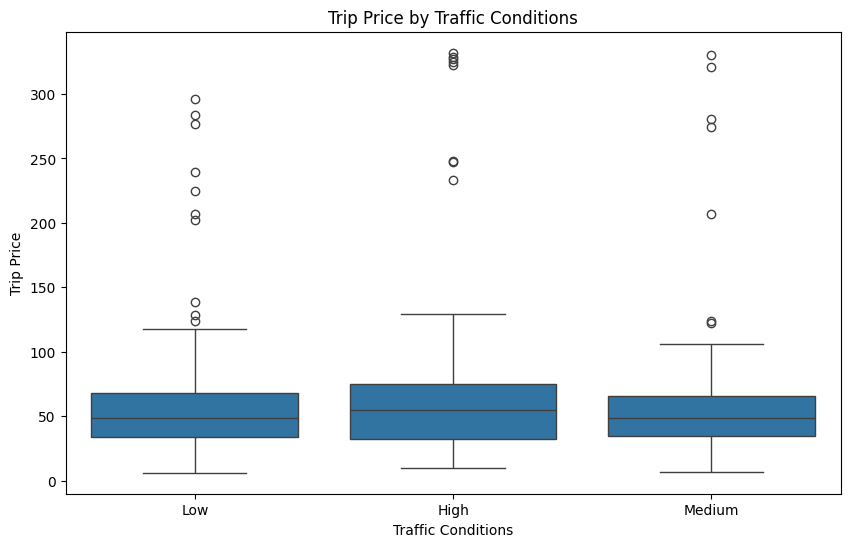

C:\Users\SWETA\AppData\Local\Temp\ipykernel_29744\1559518969.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_price_by_weather, x='Weather', y='Trip_Price', palette='viridis')


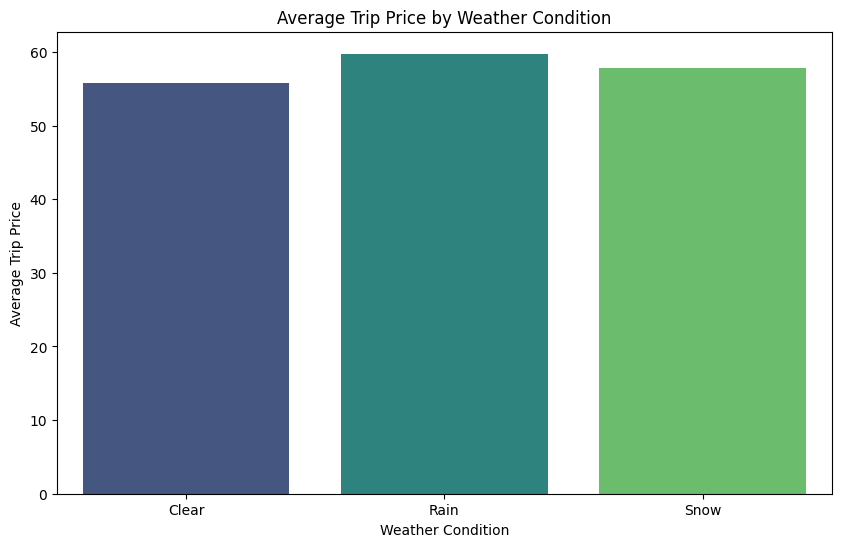

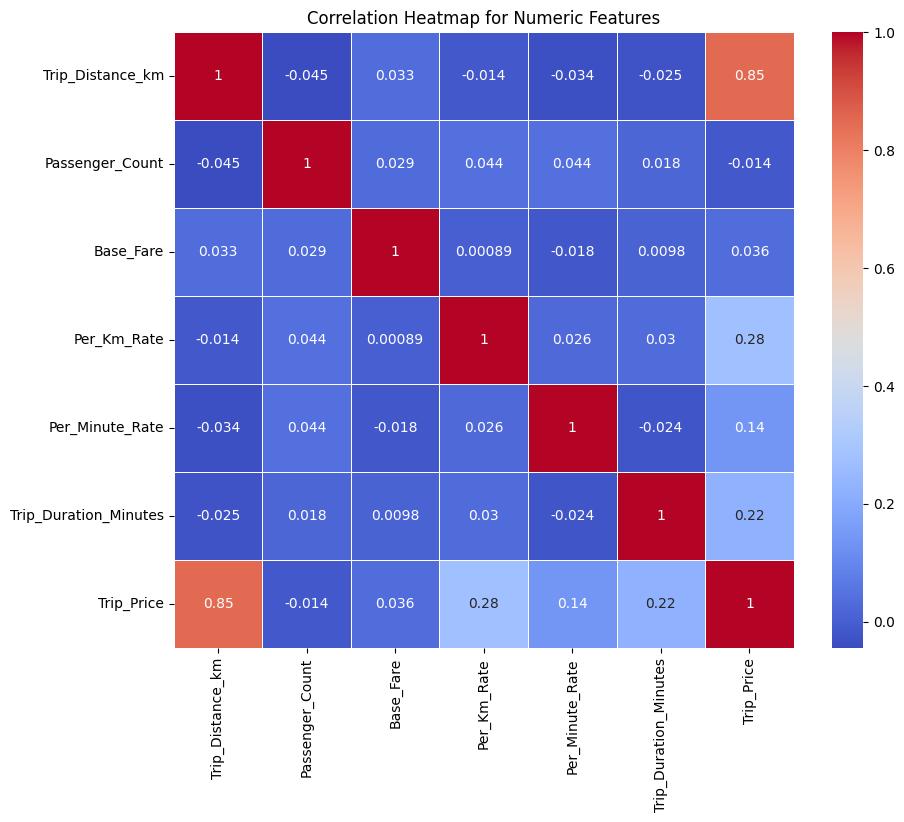

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization 1: Distribution of Trip_Price
plt.figure(figsize=(10, 6))
sns.histplot(df['Trip_Price'], kde=True, bins=30)
plt.title("Distribution of Trip Price")
plt.xlabel("Trip Price")
plt.ylabel("Frequency")
plt.show()

# Visualization 2: Scatter Plot of Trip_Distance vs. Trip_Price (colored by Time_of_Day)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Trip_Distance_km', y='Trip_Price', hue='Time_of_Day')
plt.title("Trip Distance vs. Trip Price by Time of Day")
plt.xlabel("Trip Distance (km)")
plt.ylabel("Trip Price")
plt.legend(title="Time of Day")
plt.show()

# Visualization 3: Box Plot of Trip_Price by Traffic_Conditions
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Traffic_Conditions', y='Trip_Price')
plt.title("Trip Price by Traffic Conditions")
plt.xlabel("Traffic Conditions")
plt.ylabel("Trip Price")
plt.show()

# Visualization 4: Bar Plot of Average Trip_Price by Weather Condition
avg_price_by_weather = df.groupby('Weather')['Trip_Price'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_price_by_weather, x='Weather', y='Trip_Price', palette='viridis')
plt.title("Average Trip Price by Weather Condition")
plt.xlabel("Weather Condition")
plt.ylabel("Average Trip Price")
plt.show()

# Visualization 5: Correlation Heatmap for Numeric Features
numeric_features = ['Trip_Distance_km', 'Passenger_Count', 'Base_Fare', 
                    'Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes', 'Trip_Price']
plt.figure(figsize=(10, 8))
corr_matrix = df[numeric_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap for Numeric Features")
plt.show()

In [6]:
# 4. Feature Engineering
# Creating average speed feature (km/h)
df_clean["Average_Speed_km_h"] = df_clean["Trip_Distance_km"] / (df_clean["Trip_Duration_Minutes"] / 60.0)

# Mapping 'Traffic_Conditions' from ordinal strings to numeric values
traffic_mapping = {'Low': 1, 'Medium': 2, 'High': 3}
df_clean['Traffic_Conditions'] = df_clean['Traffic_Conditions'].map(traffic_mapping)

# Creating a weekend indicator
df_clean["is_weekend"] = df_clean["Day_of_Week"].isin(["Saturday","Sunday"]).astype(int)

# Creating a combined feature for Weather and Traffic
df_clean["Weather_Traffic"] = df_clean["Weather"].astype(str) + "_" + df_clean["Traffic_Conditions"].astype(str)

In [7]:
# 5. Defining Features and Target
features = [
    'Trip_Distance_km', 'Passenger_Count', 'Base_Fare', 
    'Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes',
    'Time_of_Day', 'Day_of_Week', 'Traffic_Conditions', 'Weather',
    'Average_Speed_km_h'
]
target = 'Trip_Price'

# Dropping the rows that remain missing after feature engineering
df_clean = df_clean.dropna(subset=features)  
print("Shape after feature engineering and dropping rows with missing feature values:", df_clean.shape)

X = df_clean[features]
y = df_clean[target]

Shape after feature engineering and dropping rows with missing feature values: (545, 14)


In [8]:
from sklearn.model_selection import train_test_split

In [9]:
# 6. Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (436, 11)
Test set shape: (109, 11)


In [11]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [12]:
# 7. Preprocessing Pipeline
numeric_features = [
    'Trip_Distance_km', 'Passenger_Count', 'Base_Fare', 
    'Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes',
    'Average_Speed_km_h'
]
# Treating 'Traffic_Conditions' as numeric after mapping
numeric_features_with_traffic = numeric_features + ['Traffic_Conditions']

categorical_features = ['Time_of_Day', 'Day_of_Week', 'Weather']

numeric_transformer = Pipeline(steps=[
    ('imputer', IterativeImputer(random_state=42, max_iter=10)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features_with_traffic),
    ('cat', categorical_transformer, categorical_features)
])

In [13]:
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [14]:
# 8. Ensemble Model (stacking)
xgb_est = XGBRegressor(random_state=42, objective='reg:squarederror',
                       n_estimators=200, max_depth=4, learning_rate=0.05,
                       subsample=0.8, colsample_bytree=1.0)
rf_est = RandomForestRegressor(random_state=42, n_estimators=150, max_depth=8)
gbr_est = GradientBoostingRegressor(random_state=42, n_estimators=200, max_depth=3, learning_rate=0.05)
lgbm_est = LGBMRegressor(random_state=42, n_estimators=200, max_depth=4, learning_rate=0.05, subsample=0.8)

stack = StackingRegressor(
    estimators=[
        ('xgb', xgb_est),
        ('rf', rf_est),
        ('gbr', gbr_est),
        ('lgbm', lgbm_est)
    ],
    final_estimator=Ridge(alpha=1.0),
    cv=5,
    n_jobs=-1
)

pipeline_stack_poly = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('stack', stack)
])

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

Mean Squared Error (MSE): 7.396522983339447
Root Mean Squared Error (RMSE): 2.7196549382852684
Mean Absolute Error (MAE): 2.0162317512825685
R² Score (Accuracy): 0.9861203985416884


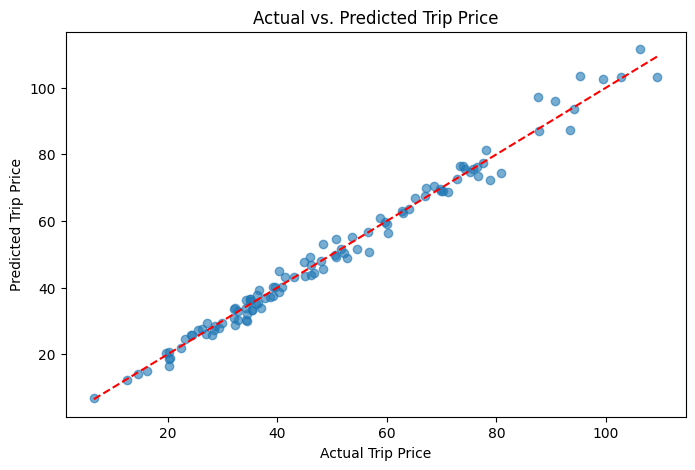

In [16]:
# 9. Log Transform the target
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Fit on the log-transformed target
pipeline_stack_poly.fit(X_train, y_train_log)

# Predicting on test set and invert
y_pred_log = pipeline_stack_poly.predict(X_test)
y_pred = np.expm1(y_pred_log)

# 10. Evaluating the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R² Score (Accuracy):", r2)

# 10. Visualization of Actual vs. Predicted Trip Price
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("Actual Trip Price")
plt.ylabel("Predicted Trip Price")
plt.title("Actual vs. Predicted Trip Price")
plt.show()


In [17]:
import joblib

# Save the trained model
joblib.dump(pipeline_stack_poly, 'taxi_fare_model.pkl')
print("Model saved as taxi_fare_model.pkl")

Model saved as taxi_fare_model.pkl
